# A Distributional Perspective on Reinforcement Learning

 이 jupyter notebook은 논문 [A Distributional Perspective on Reinforcement Learning](https://arxiv.org/abs/1707.06887)의 알고리즘 (C51)을 gym의 Cartpole 환경에서 구현한 notebook 입니다. 본 notebook의 경우 알고리즘의 구현에 관련된 설명 위주로 할 예정입니다. 논문의 이론 대한 더 자세한 내용은 readme를 참고해주세요!!

## 1. 라이브러리 불러오기

본 알고리즘의 구현을 위한 라이브러리들을 불러오는 부분입니다. 

In [0]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from timeit import default_timer as timer
from datetime import timedelta

## 2. 파라미터 설정

알고리즘의 구현을 위한 파라미터들을 설정하는 부분입니다.<br>
C51이 [Deep Q Network](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)에 비해 추가되는 파라미터는 support와 관련된 것들입니다.<br>

Supports는 각각이 value를 의미합니다. <br>
그리고 해당 support가 가지는 값은 해당 support의 값을 받을 확률을 나타냅니다. <br>
그리고 이 모든 support와 그 값들의 기대값이 Q값이 됩니다. <br>


다음의 3가지 파라미터들을 설정해주어야 합니다.
- $N$: Support의 수
- $V_{min}$: Support의 최소값
- $V_{max}$: Support의 최대값

해당 파라미터들에 대한 설명은 다음과 같습니다. <br>

<center>
    <img src="https://github.com/reinforcement-learning-kr/distributional_rl/blob/master/1_CartPole_C51/Images/support_and_prob.png?raw=true" alt="support and probability" style="width:1000px;"/>
</center>

이외의 파라미터들에 대한 설명은 다음과 같습니다. 

In [154]:
# 미니배치
MINIBATCH_SIZE = 64
# 학습 시작할 프레임
TRAIN_START = 1000
# 타겟 네트워크 갱신
TARGET_UPDATE = 25
# Replay Memory 크기
MEMORY_SIZE = 10000
# 학습률
LEARNING_RATE = 0.001
# discount factor
DISCOUNT = 0.9
# Support 개수
NUM_C = 51
# Support 범위
V_min, V_max = -10, 10
dz = float(V_max - V_min) / (NUM_C - 1)

# 환경
env = gym.make('CartPole-v0')
INPUT = env.observation_space.shape[0]
OUTPUT = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## 3. 네트워크 설정

C51 알고리즘은 support들은($z_i$) 고정한 상태로 각 value를 받을 확률을($p_i$) 추정합니다. <br>
이때 다음의 그림과 같이 네트워크의 output이 각 support에 대한 값을 추정하고 이 값들을 softmax해주어 확률로 표현합니다.<br>

<center>
    <img src="https://github.com/reinforcement-learning-kr/distributional_rl/blob/master/1_CartPole_C51/Images/network_output.png?raw=true" alt="network output" style="width:800px;"/>
</center>

이 distribution은 각 action에 대해서 구해주어야합니다. 
그렇기 때문에 network의 output의 개수 -> $|A|\times N$ ($|A|$: Action의 수, $N$: support의 수)

DQN과 동일하게 network은 `일반 network`와 `target network` 2가지가 필요합니다. 

### 일반 네트워크 구성

In [0]:
def _noisy_dense(X, n_input, n_output, name_layer, trainable):
      
      W_mu = tf.get_variable("W_mu_" + name_layer, shape=[n_input, n_output],
                                   initializer=tf.random_uniform_initializer(-tf.sqrt(3 / n_input), tf.sqrt(3 / n_input)),
                                   trainable=trainable)
      
      W_sig = tf.get_variable("W_sig_" + name_layer, shape=[n_input, n_output],
                                    initializer=tf.constant_initializer(0.017), trainable=trainable)
      
      B_mu = tf.get_variable("B_mu_" + name_layer, shape=[1, n_output],
                                   initializer=tf.random_uniform_initializer(-tf.sqrt(3 / n_input),
                                                                             tf.sqrt(3 / n_input)),
                                   trainable=trainable)
      
      B_sig = tf.get_variable("B_sig_" + name_layer, shape=[1, n_output],
                                    initializer=tf.constant_initializer(0.017), trainable=trainable)
      
      W_fc = tf.add(W_mu, tf.multiply(W_sig, tf.random_normal(shape=[n_input, n_output])))
      
      B_fc = tf.add(B_mu, tf.multiply(B_sig, tf.random_normal(shape=[1, n_output])))
      
      pre_noisy_layer = tf.add(tf.matmul(X, W_fc), B_fc)
      
      return pre_noisy_layer

In [0]:
class C51DQNAgent:
    def __init__(self, sess, a_dim, s_dim, scope, trainable,
                 learning_rate=1e-3,
                 gamma=0.99,
                 batch_size=64,
                 buffer_size=10000,
                 num_c=51,
                 V_min=-10.,
                 V_max=10.
                 ):
        # 기본 파라메터 설정
        self.memory = []
        self.iter = 0
        self.sess = sess
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.buffer_size = buffer_size
        self.num_c = num_c
        self.V_min = V_min
        self.V_max = V_max
        self.dz = float(self.V_max - self.V_min) / (self.num_c - 1)
        self.z = [self.V_min + i * self.dz for i in range(self.num_c)]
        self.a_dim, self.s_dim, = a_dim, s_dim
        self.scope = scope
        self.trainable = trainable
        
        # placeholder 설정
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.A = tf.placeholder(tf.float32, [None, 1], 'a')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')
        self.D = tf.placeholder(tf.int32, [None, 1], 'd')
        self.M = tf.placeholder(tf.float32, [None, self.num_c], 'm_prob')
        
        # 네트워크 Build
        self.dist_q, self.q_mean = self._build_net(self.S, scope=self.scope, trainable=self.trainable)
        
        # 학습 파라메터 지정
        self.q_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.scope)
        
        # 배치 샘플에 해당되는 action indices 만 학습하도록 gathering        
        a_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), tf.squeeze(tf.to_int32(self.A))], axis=1)
        self.dist_q_eval_a = tf.gather_nd(params=self.dist_q, indices=a_indices)
        # dist_q_eval_a shape : [batch size, num_c]
        
        # Argmax(Q')에 해당되는 action indices 만 gathering 
        a_next_max_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32),
                                       tf.squeeze(tf.to_int32(tf.argmax(self.q_mean, axis=1)))], axis=1)
        self.dist_q_next_a = tf.gather_nd(params=self.dist_q, indices=a_next_max_indices)
        
        # Loss 설정
        self.loss = - tf.reduce_mean(tf.reduce_sum(tf.multiply(self.M, tf.log(self.dist_q_eval_a + 1e-20)), axis=1))
        
        # 옵티마이저 설정
        self.train_op = tf.train.AdamOptimizer(self.learning_rate, epsilon=0.01/self.batch_size).minimize(self.loss, var_list=self.q_params)
       
    
    def _build_net(self, s, scope, trainable):
      with tf.variable_scope(scope):
        net = tf.nn.selu(_noisy_dense(s, self.s_dim, 512, "layer1", trainable=trainable))
        net = tf.nn.selu(_noisy_dense(net, 512, 128, "layer2", trainable=trainable))
        q_logits_flat = _noisy_dense(net, 128, self.a_dim * self.num_c, "layer3", trainable=trainable)
        q_logits_re = tf.reshape(q_logits_flat, [-1, self.a_dim, self.num_c])
        dist_q = tf.nn.softmax(q_logits_re, axis=2, name='dist_q')

        z_space = tf.tile(tf.reshape(self.z, [1, 1, self.num_c]), [tf.shape(q_logits_re)[0], self.a_dim, 1])
        Q_mean = tf.reduce_sum(tf.multiply(z_space, dist_q), axis=2)
      
      return dist_q, Q_mean
        
    def choose_action(self, state):
      state = state[np.newaxis, :] #state dimension 수정
      actions_value = self.sess.run(self.q_mean, feed_dict={self.S: state}) # Q value 계산
      action = np.argmax(actions_value) # action(argmax Q) 선택
      return action

In [0]:
tf.reset_default_graph()
sess = tf.Session()
agent = C51DQNAgent(sess, OUTPUT, INPUT, 'eval', True)

### 타겟 네트워크 구성

In [0]:
agent_target = C51DQNAgent(sess, OUTPUT, INPUT, 'target', False)

## 4. Loss 설정 및 학습

 Distributional RL 의 loss는 `target distribution`과 `추정된 distribution 중 실제 취한 action에 대한 distribution`간의 차이입니다. <br>

 원래 distributional RL의 수렴성을 확보하기 위해서는 `Wasserstein Distance`를 이용하여 두 distribution의 차이를 결정해주어야 합니다. <br>
 하지만 본 논문에서는 `Cross entropy`를 이용하여 두 distribution의 차이를 결정합니다. <br>
 이에 따라 C51 논문은 수학적으로 수렴성을 입증하지 못한 논문이라 할 수 있습니다. <br>
 <center>
    <img src="https://github.com/reinforcement-learning-kr/distributional_rl/blob/master/1_CartPole_C51/Images/cross_entropy_loss.png?raw=true" alt="Cross entropy loss" style="width:800px;"/>
</center>

## 5. Session 초기화

In [0]:
sess.run(tf.global_variables_initializer())

## 6. 함수 설정

 이 부분은 알고리즘을 구현하는데 필요한 함수들을 구현해놓은 부분입니다. <br>
 각 함수에 대한 간단한 설명은 다음과 같습니다. 

In [0]:
def projection_dist(br, bs_, bd):
    m_prob = np.zeros([MINIBATCH_SIZE, NUM_C])

    p_next_a = sess.run(agent_target.dist_q_next_a, feed_dict={agent_target.S: bs_})
    
    for j in range(NUM_C):
        Tz = np.fmin(V_max, np.fmax(V_min, br + (1 - bd) * DISCOUNT * (V_min + j * dz)))
        bj = (Tz - V_min) / dz
        lj = np.floor(bj).astype(int)
        uj = np.ceil(bj).astype(int)
        blj = bj - lj
        buj = uj - bj
        m_prob[np.arange(MINIBATCH_SIZE), lj[np.arange(MINIBATCH_SIZE), 0]] += \
            (bd[:, 0] + (1 - bd[:, 0]) * (p_next_a[:, j])) * buj[:, 0]
        m_prob[np.arange(MINIBATCH_SIZE), uj[np.arange(MINIBATCH_SIZE), 0]] += \
            (bd[:, 0] + (1 - bd[:, 0]) * (p_next_a[:, j])) * blj[:, 0]

    m_prob = m_prob / m_prob.sum(axis=1, keepdims=1)

    return m_prob

In [0]:
def update_target_net():
  
  params_replace = [tf.assign(qt, qe) for qt, qe in zip(agent_target.q_params, agent.q_params)]
  
  sess.run(params_replace)

In [0]:
def replay_memory_add(memory_buffer,s,a,r,s_,d):
  memory_buffer += [(s,a,r,s_,d)]
  if len(memory_buffer) > MEMORY_SIZE:
    memory_buffer = memory_buffer[-MEMORY_SIZE:]
  
  return memory_buffer

In [0]:
def learn(memory_buffer):
  minibatch = np.vstack(random.sample(memory_buffer, MINIBATCH_SIZE))
  bs = np.vstack(minibatch[:, 0])
  ba = np.vstack(minibatch[:, 1])
  br = np.vstack(minibatch[:, 2])
  bs_ = np.vstack(minibatch[:, 3])
  bd = np.vstack(minibatch[:, 4])

  m_prob = projection_dist(br, bs_, bd)

  sess.run(agent.train_op, {agent.S: bs, agent.A: ba, agent.M: m_prob})

## 7. Main

 이 부분은 메인 알고리즘입니다. <br>
 진행 순서는 다음과 같습니다. 

Episode:1 | Frames:10 | Reward:10.0 |Recent reward:5.0
Episode:2 | Frames:20 | Reward:10.0 |Recent reward:6.666666666666667
Episode:3 | Frames:29 | Reward:9.0 |Recent reward:7.25
Episode:4 | Frames:41 | Reward:12.0 |Recent reward:8.2
Episode:5 | Frames:50 | Reward:9.0 |Recent reward:8.333333333333334
Episode:6 | Frames:61 | Reward:11.0 |Recent reward:8.714285714285714
Episode:7 | Frames:70 | Reward:9.0 |Recent reward:8.75
Episode:8 | Frames:79 | Reward:9.0 |Recent reward:8.777777777777779
Episode:9 | Frames:89 | Reward:10.0 |Recent reward:8.9
Episode:10 | Frames:99 | Reward:10.0 |Recent reward:9.0
Episode:11 | Frames:109 | Reward:10.0 |Recent reward:9.083333333333334
Episode:12 | Frames:119 | Reward:10.0 |Recent reward:9.153846153846153
Episode:13 | Frames:128 | Reward:9.0 |Recent reward:9.142857142857142
Episode:14 | Frames:136 | Reward:8.0 |Recent reward:9.066666666666666
Episode:15 | Frames:145 | Reward:9.0 |Recent reward:9.666666666666666
Episode:16 | Frames:156 | Reward:11.0 |Rece

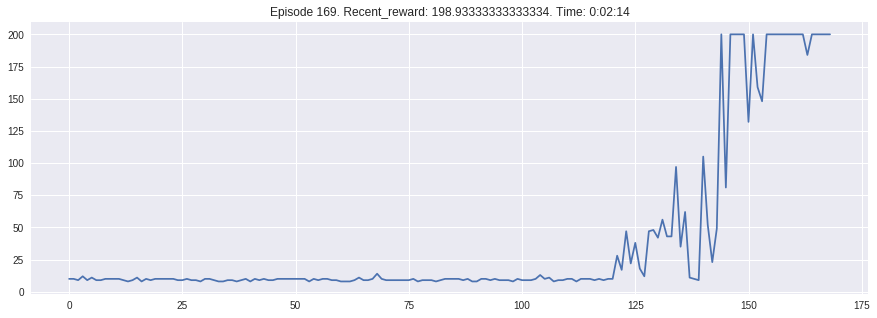

In [164]:
all_rewards = []
recent_rlist = deque(maxlen=15)
recent_rlist.append(0)
episode, frame = 0, 0
start = timer()
memory_buffer = []

# Train agent
while np.mean(recent_rlist) <= 197:
  episode += 1

  rall, count = 0, 0
  done = False
  s = env.reset()

  while not done:
    frame += 1
    count += 1

    action = agent.choose_action(s)

    s_, r, done, l = env.step(action)

    replay_memory_add(memory_buffer, s, action.astype(float), r, s_, int(done))
    s = s_

    rall += r

    if frame > TRAIN_START:
      if (frame - TRAIN_START) % TARGET_UPDATE == 0:
        update_target_net()
      
      learn(memory_buffer)
      
  recent_rlist.append(rall)
  all_rewards.append(rall)

  print("Episode:{} | Frames:{} | Reward:{} |Recent reward:{}".format(episode, frame, rall,
                                                                                np.mean(recent_rlist)))


plt.figure(figsize=(15, 5))
plt.title('Episode %s. Recent_reward: %s. Time: %s' % (
            len(all_rewards), np.mean(recent_rlist), timedelta(seconds=int(timer() - start))))
plt.plot(all_rewards)
plt.show()